In [679]:
# Load needed modules
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import math
import subprocess

In [678]:
# Update datasets
!cd nyt-data; git pull
!cd jhu-data; git pull

Already up to date.
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 143 (delta 88), reused 90 (delta 88), pack-reused 52
Receiving objects: 100% (143/143), 469.44 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (98/98), completed with 22 local objects.
From github.com:CSSEGISandData/COVID-19
   865c933c..f3dea791  master     -> origin/master
   0204c192..2979e096  web-data   -> origin/web-data
Updating 865c933c..f3dea791
Fast-forward
 csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv   | 7141 ++++++++++----------
 .../csse_covid_19_daily_reports/04-06-2020.csv     | 2810 ++++++++
 .../time_series_covid19_confirmed_US.csv           | 6508 +++++++++---------
 .../time_series_covid19_confirmed_global.csv       |  527 +-
 .../time_series_covid19_deaths_US.csv              | 6508 +++++++++---------
 .../time_series_covid19_deaths_global.csv          |  527 +-
 .../time_series_covid19_recovered_gl

In [680]:
exec(open('fetch_wikipedia_covid_data.py').read())

In [681]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   CovidPlots.ipynb
	modified:   jhu-data (new commits)
	modified:   wiki-data-it.csv
	modified:   wiki-data-sk.csv

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.~lock.world_pop_data.csv#
	italy/

no changes added to commit (use "git add" and/or "git commit -a")


In [682]:
# Load Population datasets
us_pop_data_filepath = './us_pop_data.csv'
us_state_pop_df = pd.read_csv(us_pop_data_filepath)
us_state_pop_df = us_state_pop_df.set_index(us_state_pop_df.state)

country_pop_data_filepath = './world_pop_data.csv'
country_pop_df = pd.read_csv(country_pop_data_filepath)
country_pop_df = country_pop_df.set_index([country_pop_df.country,
                                           country_pop_df.region,
                                           country_pop_df.subregion])

In [683]:
# Load NYT dataset
nyt_state_filepath = './nyt-data/us-states.csv'
nyt_state_df = pd.read_csv(nyt_state_filepath)
nyt_state_df.date = pd.to_datetime(nyt_state_df.date)
nyt_state_df = nyt_state_df.set_index(nyt_state_df.date)[['state', 'fips', 'cases', 'deaths']]

In [684]:
## Build dictionary of state data.
per_state_data = {}
idx = nyt_state_df.index.to_pydatetime()
for s, g in nyt_state_df.groupby(nyt_state_df.state):
    daily_new_cases = (g.cases-g.cases.shift(1))
    daily_new_deaths = (g.deaths.shift(1)-g.deaths)
    state_data_df = pd.DataFrame({'cases':g.cases, 'new_cases':daily_new_cases,
                                  'deaths':g.deaths, 'new_deaths':daily_new_deaths,
                                  'case_density':g.cases/us_state_pop_df.loc[s, 'pop_2019'],
                                  'death_density':g.deaths/us_state_pop_df.loc[s, 'pop_2019']},
                                 index=g.index).dropna()
    per_state_data[s] = state_data_df

# get min and max date
min_date = min(per_state_data['Illinois'].index)
max_date = max(per_state_data['Illinois'].index)
for state in per_state_data:
    min_date = min(min_date, min(per_state_data[state].index))
    max_date = max(max_date, max(per_state_data[state].index))

In [697]:
# Load JHU dataset
jhu_global_filepath = './jhu-data/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
jhu_global_df = pd.read_csv(jhu_global_filepath)

# Remove lat/long
column_names = jhu_global_df.columns
column_names = list(filter(lambda n: n not in ['Lat', 'Long'],column_names))

# Combine country regions together
jhu_global_df = jhu_global_df[column_names]
jhu_country_df = jhu_global_df.groupby('Country/Region').sum()

per_country_data = {}
for country_name in jhu_country_df.index:
    country_series = jhu_country_df.loc[country_name, :]
    country_new_cases = country_series-country_series.shift(1)
    try:
        case_density = country_series/country_pop_df.loc[(country_name, np.nan, np.nan), 'pop_2020']
        country_df = pd.DataFrame({'cases': country_series, 'new_cases':country_new_cases,
                                   'case_density': case_density},
                                  index=pd.to_datetime(country_series.index, format='%m/%d/%y')).dropna()
    except:
        country_df = pd.DataFrame({'cases': country_series, 'new_cases':country_new_cases},
                                  index=pd.to_datetime(country_series.index, format='%m/%d/%y')).dropna()
    country_df.new_cases = country_df.new_cases.astype(np.int64)
    per_country_data[country_name] = country_df

# Split country_regions up
jhu_province_df = jhu_global_df.groupby(['Country/Region', 'Province/State']).sum()
per_province_data = {}
for province_idx in jhu_province_df.index:
    province_series = jhu_province_df.loc[province_idx, :]
    province_new_cases = province_series-province_series.shift(1)
    try:
        case_density = province_series/country_pop_df.loc[province_idx+(np.nan,), 'pop_2020']
        province_df = pd.DataFrame({'cases': province_series, 'new_cases': province_new_cases,
                                    'case_density': case_density},
                                    index=pd.to_datetime(province_series.index, format='%m/%d/%y')).dropna()
    except:
        province_df = pd.DataFrame({'cases': province_series, 'new_cases': province_new_cases},
                                    index=pd.to_datetime(province_series.index, format='%m/%d/%y')).dropna()
    province_df.new_cases = province_df.new_cases.astype(np.int64)
    per_province_data[province_idx] = province_df

In [428]:
## Produce animation over all days
def time_animated_2d_scatter(dfs, x='cases', y='new_cases',
                             xname=None, yname=None,
                             trail_length=5, **kwargs):
    """
    Function to plot an animation over time of two variables.

    Named Arguments
        dfs: A dictionary of pandas dataframes. The key is the name you want
            that data labelled as. The dataframe should be date indexed, and contain
            'cases' and 'new_cases' columns.

    Keyword Arguments
        x: A string name of the column to use for the x axis.

        y: A string name of the column to use for the y axis.

        xname: Name to use for the x axis.

        yname: Name to use for the y axis.
        
        trail_length: An integer specifying how many points of the past to show.

    returns: A Matplotlib FuncAnimation object containing the animation.
    """

    if xname is None:
        xname = x
    if yname is None:
        yname = y
    
    # Get list of names
    names = list(dfs.keys())

    # Find min and max cases and new_cases
    max_x = 0
    max_y = 0
    for name in names:
        max_x = max(max_x, max(dfs[name][x]))
        max_y = max(max_y, max(dfs[name][y]))

    # Initialization for animation
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    figsize = kwargs.pop('figsize', (15,5))
    fig, ax = plt.subplots(1, figsize=figsize)

    # Lines for histories
    line_plots_x = {}
    line_plots_y = {}
    line_histories = {}
    for name in names:
        line_plots_x[name] = []
        line_plots_y[name] = []
        line_histories[name], = ax.plot(line_plots_x[name], line_plots_y[name], '-', color='k', alpha=0.6)

    # state current positions
    # Initialize
    pos_x = np.zeros((len(names),))
    pos_y = np.zeros((len(names),))
    pos_scat = ax.scatter(pos_x, pos_y, marker='o', alpha=1., s=30)

    # label positions
    labels = {}
    for name in names:
        labels[name] = ax.text(0,0, name, fontsize=9)

    # Plot initialization function
    def init_():
        ax.set_xlim((1, 10**(math.log10(max_x)*1.05)))
        ax.set_ylim((1, 10**(math.log10(max_y*1.05))))
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)
        ax.grid(True)

    # Plot update function
    def update_(cur_date):
        ## Update data for each day
        for name in names:
            df = dfs[name]
            if cur_date in df.index:
                xval = df[cur_date:cur_date][[x]].values[0,0]
                yval = df[cur_date:cur_date][[y]].values[0,0]
                # Update data for that day
                # Label locations
                labels[name].set_position((xval,yval))
                # Lines
                line_plots_x[name].append(xval)
                line_plots_y[name].append(yval)
                if len(line_plots_x[name]) > trail_length:
                    del line_plots_x[name][0]
                if len(line_plots_y[name]) > trail_length:
                    del line_plots_y[name][0]
                # dot positions
                pos_x[names.index(name)] = xval
                pos_y[names.index(name)] = yval

        # Set title
        ax.set_title(f"{pd.to_datetime(str(cur_date)).strftime('%Y-%m-%d')}")

        # Reset object data
        for state in line_histories:
            line_histories[state].set_data(line_plots_x[state], line_plots_y[state])
            pos_scat.set_offsets(list(zip(pos_x, pos_y)))

    # Produce animation
    ani = animation.FuncAnimation(fig, update_, frames=pd.date_range(min_date, max_date),
                                  init_func=init_, blit=False)

    plt.close()
    
    return ani

In [429]:
def time_2d_plot(dfs, x='cases', y='new_cases',
                 xname=None, yname=None, **kwargs):
    """
    2d plot of various datasets over full history.
    
    Named Arguments
        dfs: A dictionary of pandas dataframes for individual populations.
            Each pandas dataframe should be indexed by date with the x and y
            columns of interest.

    Keyword Arguments
        x: A string name of the column to use for the x axis.

        y: A string name of the column to use for the y axis.

        xname: Name to use for the x axis.

        yname: Name to use for the y axis.

    returns: fig, ax -> Matplotlib Figure and Axes objects on which the
        result is plotted.
    """

    if xname is None:
        xname = x
    if yname is None:
        yname = y

    names = list(dfs.keys())

    # Find min and max x and y
    max_x = 0
    max_y = 0
    for name in names:
        max_x = max(max_x, max(dfs[name][x]))
        max_y = max(max_y, max(dfs[name][y]))

    # Plot initialization
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    figsize = kwargs.pop('figsize', (15,5))
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.grid(True)

    for name in names:
        ax.plot(dfs[name][x], dfs[name][y], '-o', markersize=3, label=name)

    plt.legend()

    return fig, ax

In [430]:
def plot_over_time(dfs, y='cases', yname=None, **kwargs):
    """
    Plot of property over time.
    
    Named Arguments
        dfs: A dictionary of pandas dataframes. keys should be the name of each dataset.
            The dataframe should be indexed by date and contain column of interest.
    
    Keyword Arguments
        y: The string name of the column to plot on the y axis.
        
        yname: The Title of the y axis to use.

    returns: (fig, ax) where fig is a Matplotlib Figure object, and ax is a
        Matplotlib Axes object where the plot is drawn.
    """
    
    if yname is None:
        yname = y

    names = list(dfs.keys())

    min_date = None
    max_date = None
    max_y = None
    for name in names:
        if min_date is None:
            min_date = min(dfs[name].index)
            max_date = max(dfs[name].index)
            max_y = max(dfs[name][y])
        else:
            min_date = min(min_date, min(dfs[name].index))
            max_date = max(max_date, max(dfs[name].index))
            max_y = max(max_y, max(dfs[name][y]))

    figsize = kwargs.pop('figsize', (15,5))
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.set_yscale('log')
    ax.set_ylabel(yname)
    ax.set_xlabel('Date')
    ax.set_title('Total cases over time')
    for name in names:
        ax.plot(dfs[name].index, dfs[name][y], '-o', markersize=3, label=name)

    ax.legend()
    ax.grid()

    return fig, ax

In [656]:
states = ['New York', 'Washington', 'Illinois', 'New Jersey']
ani = time_animated_2d_scatter({k: per_state_data[k] for k in states & per_state_data.keys()},
                               x='cases', y='new_cases', xname='Total Cases',
                               yname='Total New Cases', trail_length=10, figsize=(15,15))
HTML(ani.to_jshtml())

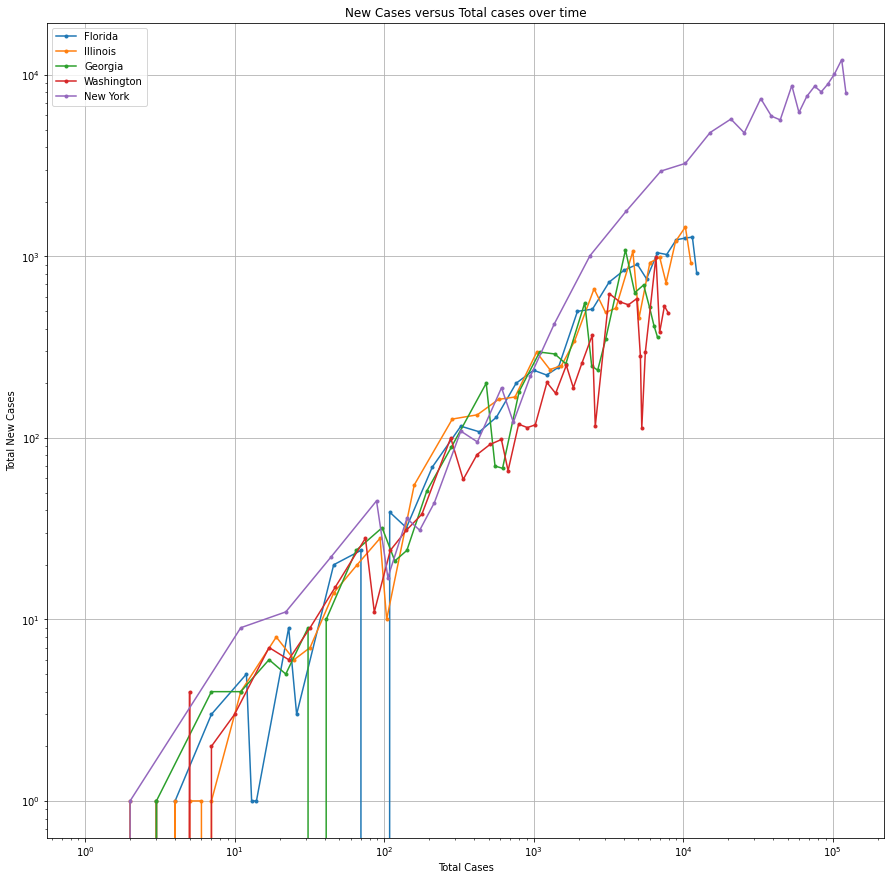

In [657]:
states = ['New York', 'Washington', 'Illinois', 'Georgia', 'Florida']
_, ax = time_2d_plot({k: per_state_data[k] for k in (states & per_state_data.keys())},
                     x='cases', y='new_cases',
                     xname='Total Cases',
                     yname='Total New Cases',
                     figsize=(15,15))
ax.set_title('New Cases versus Total cases over time')
plt.show()

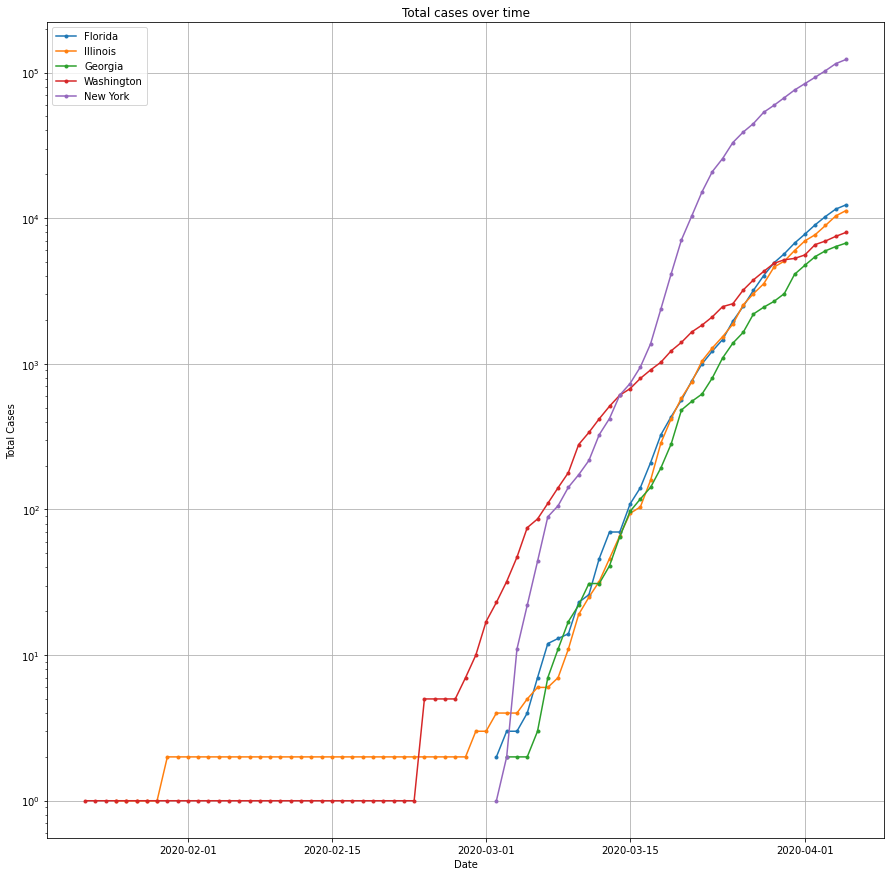

In [658]:
_, ax = plot_over_time({k: per_state_data[k] for k in states & per_state_data.keys()},
               y='cases', yname='Total Cases', figsize=(15,15))
ax.set_title('Total cases over time')
plt.show()

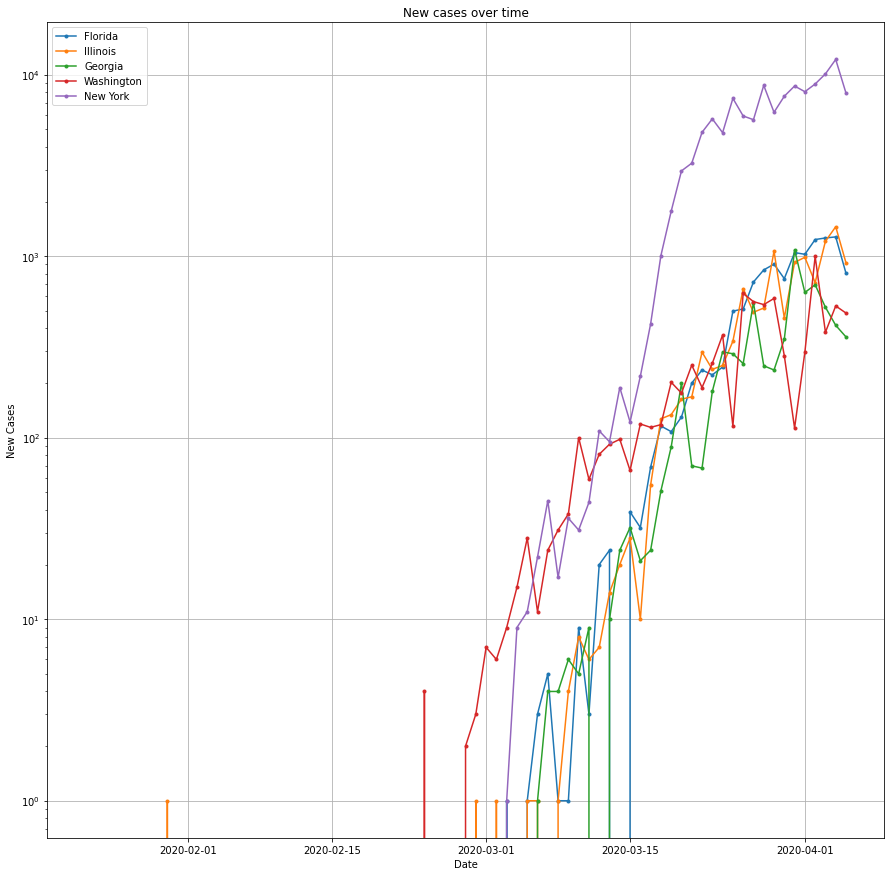

In [659]:
_, ax = plot_over_time({k: per_state_data[k] for k in states & per_state_data.keys()},
                       y='new_cases',
                       yname='New Cases',
                       figsize=(15,15))
ax.set_title('New cases over time')
plt.show()

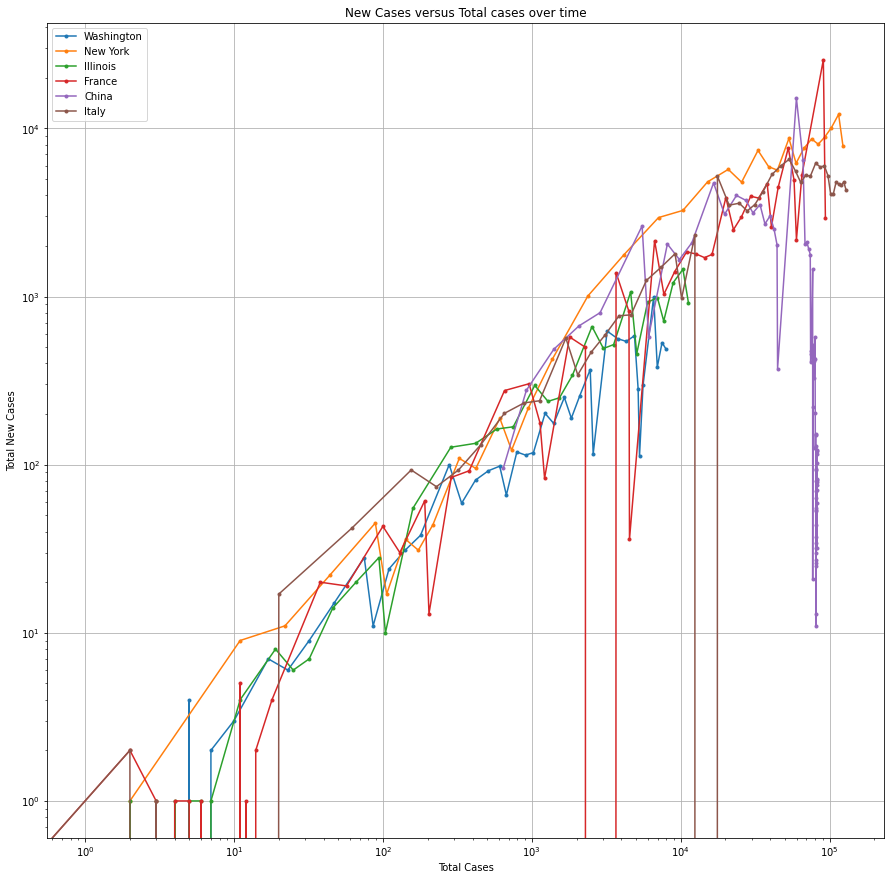

In [660]:
states = ['New York', 'Washington', 'Illinois']
state_dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
countries = ['Italy', 'China', 'France']
country_dfs = {k: per_country_data[k] for k in (countries & per_country_data.keys())}
state_dfs.update(country_dfs)
all_dfs = state_dfs

_, ax = time_2d_plot(all_dfs,
                     x='cases', y='new_cases',
                     xname='Total Cases',
                     yname='Total New Cases',
                     figsize=(15,15))
ax.set_title('New Cases versus Total cases over time')
plt.show()

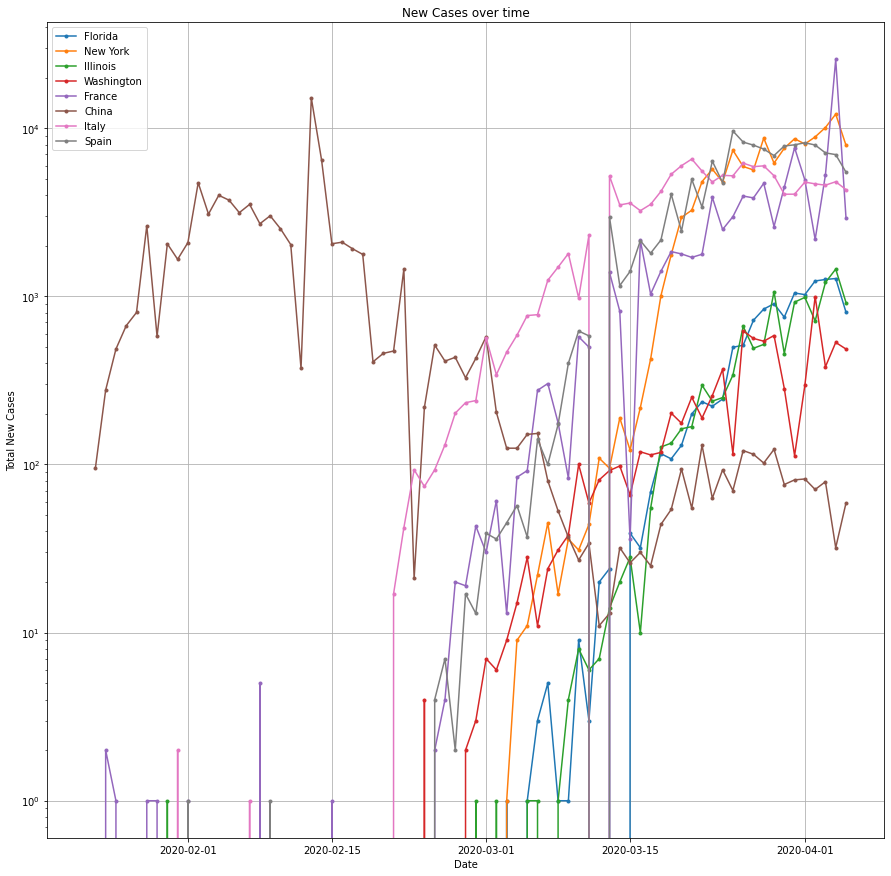

In [661]:
states = ['New York', 'Washington', 'Illinois', 'Florida']
state_dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
countries = ['Italy', 'China', 'France', 'Spain']
country_dfs = {k: per_country_data[k] for k in (countries & per_country_data.keys())}
state_dfs.update(country_dfs)
all_dfs = state_dfs

_, ax = plot_over_time(all_dfs,
                       y='new_cases',
                       yname='Total New Cases',
                       figsize=(15,15))
ax.set_title('New Cases over time')
plt.show()

In [662]:
states = ['New York', 'Washington', 'Illinois']
state_dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
countries = ['Italy', 'China', 'France']
country_dfs = {k: per_country_data[k] for k in (countries & per_country_data.keys())}
state_dfs.update(country_dfs)
all_dfs = state_dfs

anim = time_animated_2d_scatter(all_dfs,
                                x='cases', y='new_cases',
                                xname='Total Cases',
                                yname='Total New Cases',
                                trail_length=20,
                                figsize=(15,15))

plt.close()
HTML(anim.to_jshtml())

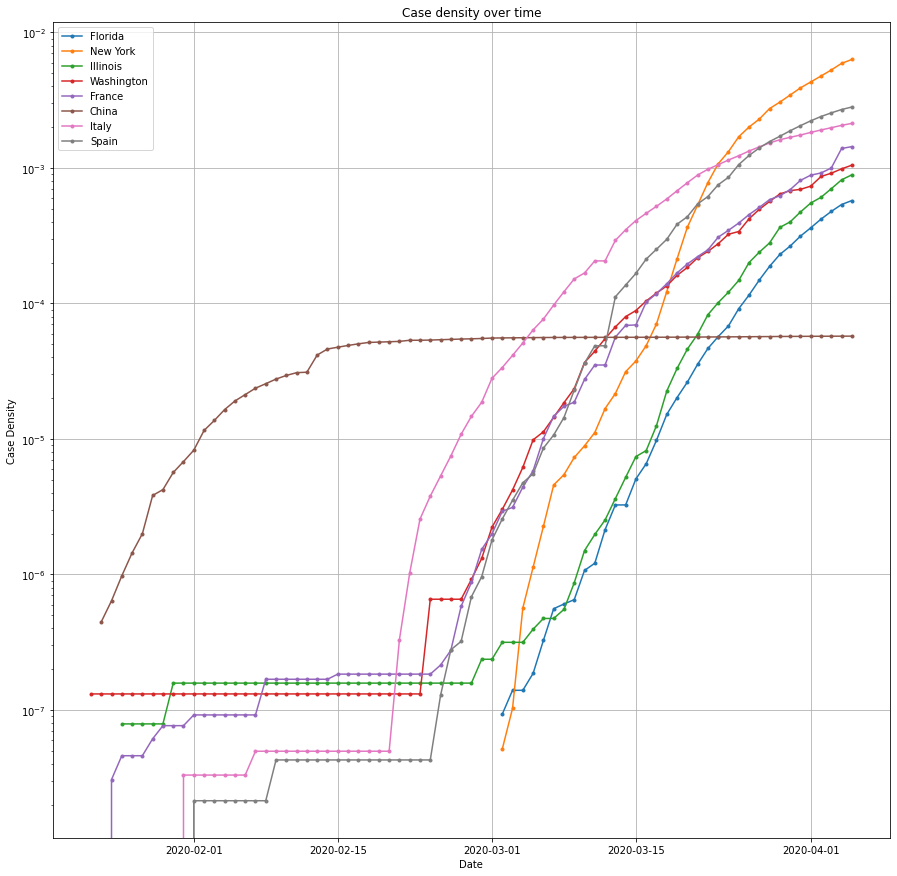

In [663]:
states = ['New York', 'Washington', 'Illinois', 'Florida']
state_dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
countries = ['Italy', 'China', 'France', 'Spain']
country_dfs = {k: per_country_data[k] for k in (countries & per_country_data.keys())}
state_dfs.update(country_dfs)
all_dfs = state_dfs

_, ax = plot_over_time(all_dfs,
                       y='case_density',
                       yname='Case Density',
                       figsize=(15,15))
ax.set_title('Case density over time')
plt.show()

In [686]:
italy_df = pd.read_csv('wiki-data-it.csv')
sk_df = pd.read_csv('wiki-data-sk.csv')

In [687]:
temp_df = italy_df.groupby(['region', 'subregion']).sum()
worst_italy_idx = temp_df[temp_df.cases == max(temp_df.cases)].index[0]

temp_df = sk_df.groupby(['region', 'subregion']).sum()
worst_sk_idx = temp_df[temp_df.cases == max(temp_df.cases)].index[0]

In [722]:
china_province_idxs = list(filter(lambda k: k[0] == 'China',list(per_province_data.keys())))
china_province_idxs = sorted(china_province_idxs, key=lambda idx: max(per_province_data[idx].cases), reverse=True)
worst_china_province_idx = china_province_idxs[0]

In [688]:
lombardy_pop = country_pop_df.loc[('Italy',) + worst_italy_idx, 'pop_2020']
lombardy_df = italy_df[italy_df.subregion == 'LOM'][['date', 'cases', 'deaths']].groupby('date').sum()
lombardy_df = lombardy_df.rename(columns={'cases':'new_cases', 'deaths':'new_deaths'})
lombardy_df['cases'] = lombardy_df.new_cases.cumsum()
lombardy_df['deaths'] = lombardy_df.new_deaths.cumsum()
lombardy_df = lombardy_df.set_index(pd.to_datetime(lombardy_df.index))
lombardy_df['case_density'] = lombardy_df.cases/lombardy_pop
lombardy_df['deaths_density'] = lombardy_df.deaths/lombardy_pop
lombardy_df

In [694]:
daegu_pop = country_pop_df.loc[('South Korea', 'Gyeongsang', 'Daegu'), 'pop_2020']
daegu_df = sk_df[sk_df.subregion == 'Daegu'][['date', 'cases', 'deaths']].groupby('date').sum()
daegu_df = daegu_df.rename(columns={'cases':'new_cases', 'deaths':'new_deaths'})
daegu_df['cases'] = daegu_df.new_cases.cumsum()
daegu_df['deaths'] = daegu_df.new_deaths.cumsum()
daegu_df = daegu_df.set_index(pd.to_datetime(daegu_df.index))
daegu_df['case_density'] = daegu_df.cases/daegu_pop
daegu_df['deaths_denstiy'] = daegu_df.deaths/daegu_pop

In [728]:
hubei_pop = country_pop_df.loc[('China', 'Hubei', np.nan), 'pop_2020']
hubei_df = per_province_data[worst_china_province_idx]

In [691]:
temp_df = italy_df.groupby(['region', 'subregion']).sum()
lombardy_idx = temp_df[temp_df.cases == max(temp_df.cases)].index[0]
print("lombardy_idx: ", lombardy_idx)

temp_df = sk_df.groupby(['region', 'subregion']).sum()
daegu_idx = temp_df[temp_df.cases == max(temp_df.cases)].index[0]
print("daegu_idx: ", daegu_idx)

lombardy_idx:  ('North-West', 'LOM')
daegu_idx:  ('Gyeongsang', 'Daegu')


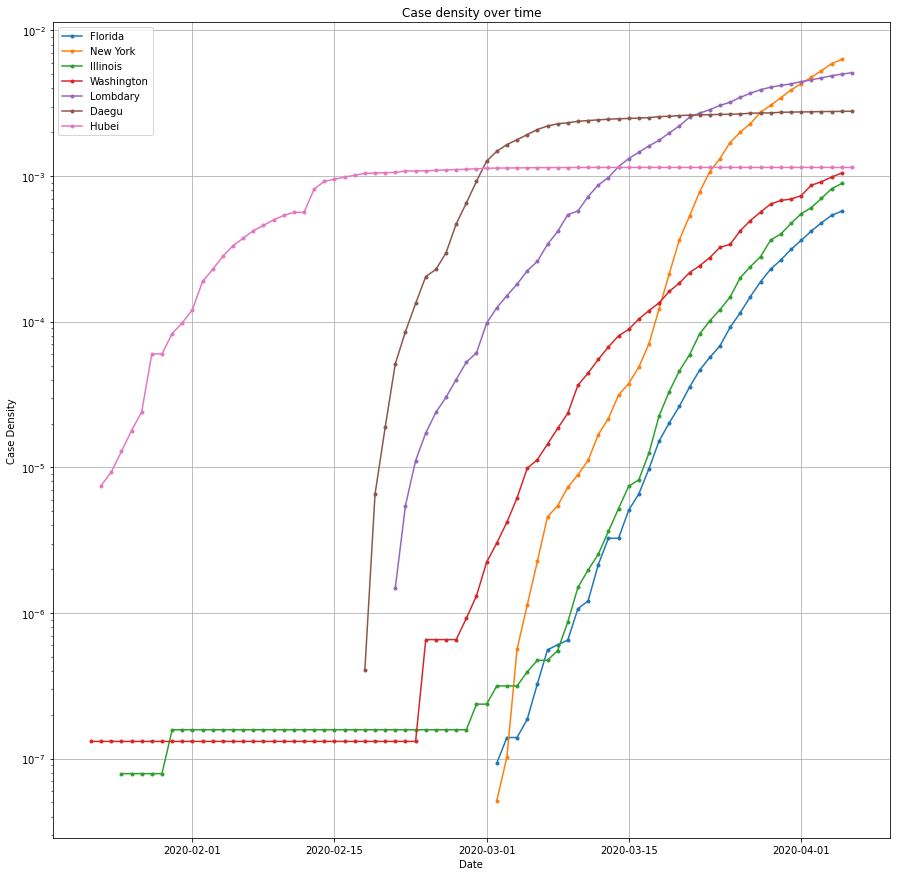

In [729]:
states = ['New York', 'Washington', 'Illinois', 'Florida']
dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
#countries = ['China', 'France', 'Spain']
#dfs.update({k: per_country_data[k] for k in (countries & per_country_data.keys())})
dfs.update({'Lombdary':lombardy_df, 'Daegu':daegu_df, 'Hubei':hubei_df})

_, ax = plot_over_time(dfs,
                       y='case_density',
                       yname='Case Density',
                       figsize=(15,15))
ax.set_title('Case density over time')
plt.show()

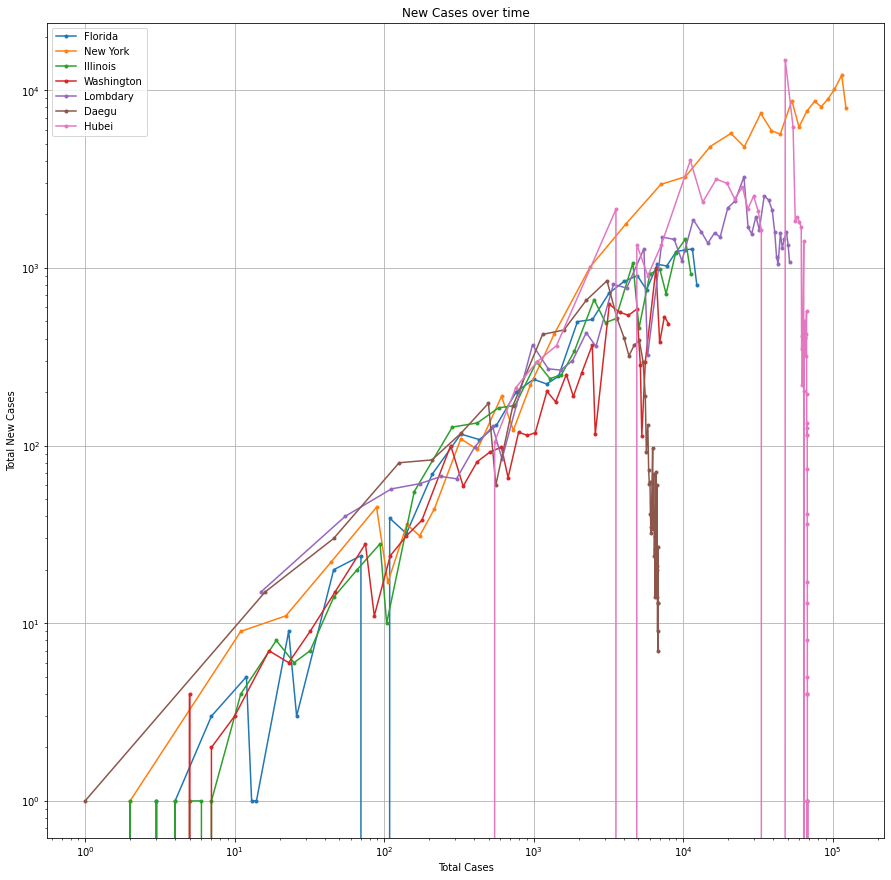

In [730]:
states = ['New York', 'Washington', 'Illinois', 'Florida']
dfs = {k: per_state_data[k] for k in (states & per_state_data.keys())}
dfs.update({'Lombdary':lombardy_df, 'Daegu':daegu_df, 'Hubei':hubei_df})

_, ax = time_2d_plot(dfs,
                     x='cases',
                     y='new_cases',
                     xname='Total Cases',
                     yname='Total New Cases',
                     figsize=(15,15))
ax.set_title('New Cases over time')
plt.show()